# Neural Network Models

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.style.use('seaborn-whitegrid')
sns.set_style("white")
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers import LSTM
from keras.layers import TimeDistributed
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.layers import ConvLSTM2D
from keras.utils import to_categorical
from keras import backend as K 
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import load_model, model_from_json
from keras.metrics import CategoricalAccuracy, CategoricalCrossentropy
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, auc, roc_curve, roc_auc_score, precision_score, recall_score, f1_score, accuracy_score, classification_report, SCORERS, log_loss

from numpy.random import seed


In [11]:
activities = {
    1: 'Walking',
    2: 'Walking Upstairs',
    3: 'Walking Downstairs',
    4: 'Sitting',
    5: 'Standing',
    6: 'Laying'
}

## Data Pipeline

In [12]:
# load a single file as a numpy array
def load_file(filepath):
    df = pd.read_csv(filepath, header=None, delim_whitespace=True)
    return df.values

# load a list of files into a 3D array of [observations, timesteps, features(x,y,z)]
def load_group(files, prefix=''):
    loaded = list()
    for f in files:
        data = load_file(prefix + f)
        loaded.append(data)
    # stack group so that features are the 3rd dimension
    loaded = np.dstack(loaded)
    return loaded

def load_dataset_group(group, prefix=''):
    filepath = prefix + group + '/Inertial Signals/'
    # load all 9 files as a single array
    files = list()
    # body acceleration
    files += ['body_acc_x_'+group+'.txt', 'body_acc_y_'+group+'.txt', 'body_acc_z_'+group+'.txt']
    # body gyroscope
    files += ['body_gyro_x_'+group+'.txt', 'body_gyro_y_'+group+'.txt', 'body_gyro_z_'+group+'.txt']
    # total acceleration
    files += ['total_acc_x_'+group+'.txt', 'total_acc_y_'+group+'.txt', 'total_acc_z_'+group+'.txt']
    # load input data
    X = load_group(files, filepath)
    # load class output
    y = load_file(prefix + group + '/y_'+group+'.txt')
    return X, y

def load_dataset(prefix=''):
    # load all train
    X_train, y_train = load_dataset_group('train', prefix)
    # load all test
    X_test, y_test = load_dataset_group('test', prefix)
    # zero-offset class values
    y_train = y_train - 1
    y_test = y_test - 1
    y_train = to_categorical(y_train)
    y_test = to_categorical(y_test)
    print(f"""Dataset loaded.
Training Set:
X_train {X_train.shape} y_train {y_train.shape}
Test Set:
X_test {X_test.shape} y_test {y_test.shape}""")
    return X_train, y_train, X_test, y_test

## Hyperparameters Tuning

In [13]:
def create_model(model):
    classifier = KerasClassifier(model, verbose=2)
    return classifier

In [14]:
# GridSearch
def grid(classifier):
    # define the grid search parameters
    batch_size = [32, 64]
    epochs = [15, 20,]
    validation_split=[0.2]
    param_grid = dict(batch_size=batch_size, epochs=epochs, validation_split=validation_split)
    grid = GridSearchCV(estimator=classifier, param_grid=param_grid, n_jobs=-1, cv=5, return_train_score=True, verbose=2)
    grid_result = grid.fit(X_train, y_train)
    # summarize results
    print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
    means = grid_result.cv_results_['mean_test_score']
    stds = grid_result.cv_results_['std_test_score']
    params = grid_result.cv_results_['params']
    for mean, stdev, param in zip(means, stds, params):
        print("%f (%f) with: %r" % (mean, stdev, param))
    return grid_result

## Evaluate Model

In [15]:
def evaluate_model(X_train, y_train, X_test, y_test, params, model):
    epochs, batch_size = params["epochs"], params["batch_size"]
    es =EarlyStopping(monitor='val_loss', patience=5)
    classifier=model()
    history = classifier.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=2, validation_split=0.2, callbacks=[es])
    # evaluate model
    _, accuracy = classifier.evaluate( X_test, y_test, batch_size=batch_size, verbose=0)
    return history, accuracy, classifier

In [16]:
def run_model(model, grid_result):
    history, score, classifier = evaluate_model(X_train, y_train, X_test, y_test, grid_result.best_params_, model)
    score = score * 100.0
    print('> %.3f' % (score))
    results=pd.DataFrame(history.history, index=history.epoch)
    return results, classifier

In [17]:
def plot_loss(results):
    plt.style.use('seaborn-whitegrid')
    sns.set(style="white", font_scale = 1.5)
    fig, axes = plt.subplots(1,2, figsize=(20,5), sharex=True)
    axes[0].set_title('Loss')
    axes[0].plot(results['loss'], label='train', )
    axes[0].plot(results['val_loss'], label='test')
    axes[0].legend()
    #plot accuracy during training
    axes[1].set_title('Accuracy')
    axes[1].plot(results['accuracy'], label='train')
    axes[1].plot(results['val_accuracy'], label='test')
    axes[1].legend()
    plt.show()
    return

In [18]:
def run(model):
    classifier=create_model(model)
    grid_result=grid(classifier)
    results, classifier=run_model(model, grid_result)
    plot_loss(results)
    return classifier

### Base Model

In [19]:
X_train, y_train, X_test, y_test = load_dataset(prefix="data/")
n_timesteps, n_features, n_outputs = X_train.shape[1], X_train.shape[2], y_train.shape[1]

Dataset loaded.
Training Set:
X_train (7352, 128, 9) y_train (7352, 6)
Test Set:
X_test (2947, 128, 9) y_test (2947, 6)


#### LSTM Network Model

In [20]:
def model1():
    seed(17)
    K.clear_session()
    model = Sequential()
    model.add(LSTM(64, input_shape=(n_timesteps,n_features)))
    model.add(Dropout(0.1))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(n_outputs, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer="adam", metrics=['accuracy'])
    return model

Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 out of  20 | elapsed: 19.8min remaining:  4.9min
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed: 25.8min finished


Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Train on 5881 samples, validate on 1471 samples
Epoch 1/20
 - 29s - loss: 1.1122 - accuracy: 0.5312 - val_loss: 1.1624 - val_accuracy: 0.4827
Epoch 2/20
 - 26s - loss: 0.7644 - accuracy: 0.6788 - val_loss: 0.8287 - val_accuracy: 0.6934
Epoch 3/20
 - 25s - loss: 0.5794 - accuracy: 0.7579 - val_loss: 0.8375 - val_accuracy: 0.7097
Epoch 4/20
 - 27s - loss: 0.5097 - accuracy: 0.7951 - val_loss: 0.7220 - val_accuracy: 0.7723
Epoch 5/20
 - 25s - loss: 0.4851 - accuracy: 0.8090 - val_loss: 0.7302 - val_accuracy: 0.7825
Epoch 6/20
 - 27s - loss: 0.4007 - accuracy: 0.8492 - val_loss: 0.8003 - val_accuracy: 0.7607
Epoch 7/20
 - 26s - loss: 0.3450 - accuracy: 0.8817 - val_loss: 0.6798 - val_accuracy: 0.8423
Epoch 8/20
 - 25s - loss: 0.2341 - accuracy: 0.9213 - val_loss: 0.5738 - val_accuracy: 0.8858
Epoch 9/20
 - 25s - loss: 0.2126 - accuracy: 0.9269 - val_loss: 0.5283 - val_acc

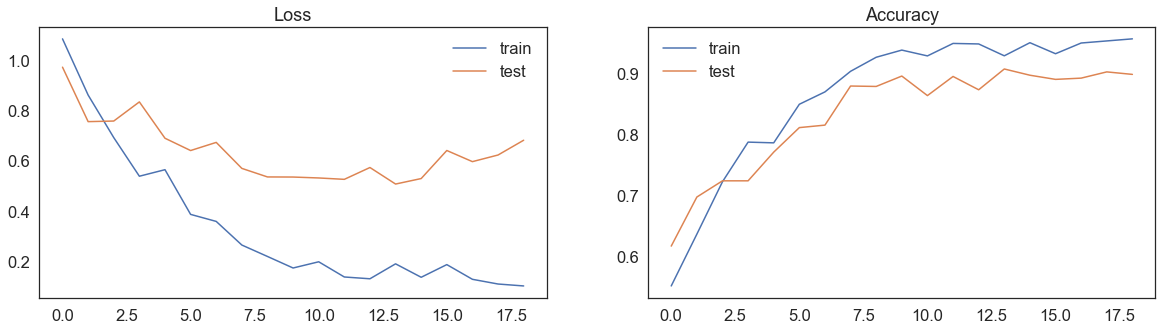

In [21]:
classifier1=run(model1)

#### CNN

In [22]:
def model2():
    seed(17)
    K.clear_session()
    model = Sequential()
    model.add(Conv1D(filters=64, kernel_size=3, activation='relu',input_shape=(n_timesteps, n_features)))
    model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
    model.add(Dropout(0.5))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Flatten())
    model.add(Dense(100, activation='relu'))
    model.add(Dense(n_outputs, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 out of  20 | elapsed: 15.0min remaining:  3.8min
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed: 16.7min finished


Train on 5881 samples, validate on 1471 samples
Epoch 1/20
 - 3s - loss: 0.5034 - accuracy: 0.7915 - val_loss: 0.3423 - val_accuracy: 0.8844
Epoch 2/20
 - 3s - loss: 0.1655 - accuracy: 0.9378 - val_loss: 0.3118 - val_accuracy: 0.8980
Epoch 3/20
 - 3s - loss: 0.1128 - accuracy: 0.9558 - val_loss: 0.3282 - val_accuracy: 0.9041
Epoch 4/20
 - 3s - loss: 0.0956 - accuracy: 0.9592 - val_loss: 0.2990 - val_accuracy: 0.8973
Epoch 5/20
 - 3s - loss: 0.0920 - accuracy: 0.9602 - val_loss: 0.3114 - val_accuracy: 0.9103
Epoch 6/20
 - 3s - loss: 0.0846 - accuracy: 0.9634 - val_loss: 0.3349 - val_accuracy: 0.9137
Epoch 7/20
 - 3s - loss: 0.0837 - accuracy: 0.9602 - val_loss: 0.3687 - val_accuracy: 0.9062
Epoch 8/20
 - 3s - loss: 0.0851 - accuracy: 0.9607 - val_loss: 0.3697 - val_accuracy: 0.9041
Epoch 9/20
 - 3s - loss: 0.0751 - accuracy: 0.9648 - val_loss: 0.3330 - val_accuracy: 0.8899
Epoch 10/20
 - 3s - loss: 0.0735 - accuracy: 0.9648 - val_loss: 0.4224 - val_accuracy: 0.9082
Epoch 11/20
 - 3s - l

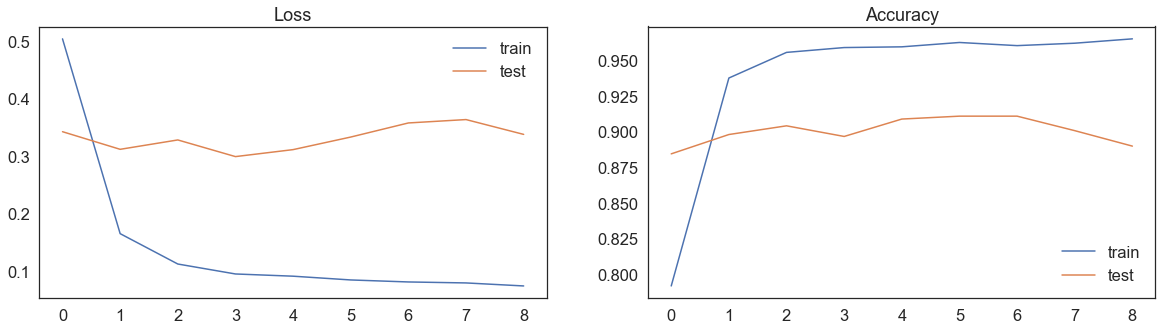

In [23]:
classifier2=run(model2)

### CNN-LSTM Network Model

In [24]:
# reshape data into time steps of sub-sequences
n_steps, n_length = 4, 32
X_train = X_train.reshape((X_train.shape[0], n_steps, n_length, n_features))
X_test = X_test.reshape((X_test.shape[0], n_steps, n_length, n_features))

In [44]:
def model3():
    seed(17)
    K.clear_session()
    model = Sequential()
    model.add(TimeDistributed(Conv1D(filters=64, kernel_size=3, activation='relu'), input_shape=(None,n_length,n_features)))
    model.add(TimeDistributed(MaxPooling1D(pool_size=2)))
    model.add(TimeDistributed(Dropout(0.5)))
    model.add(TimeDistributed(Conv1D(filters=128, kernel_size=3, activation='relu')))
    model.add(TimeDistributed(MaxPooling1D(pool_size=2)))
    model.add(TimeDistributed(Dropout(0.5)))
    model.add(TimeDistributed(Flatten()))
    model.add(LSTM(100))
    model.add(Dropout(0.5))
    model.add(Dense(100, activation='relu'))
    model.add(Dense(n_outputs, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 out of  20 | elapsed: 15.3min remaining:  3.8min
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed: 18.0min finished


Train on 5881 samples, validate on 1471 samples
Epoch 1/20
 - 6s - loss: 0.8520 - accuracy: 0.6363 - val_loss: 0.6190 - val_accuracy: 0.7811
Epoch 2/20
 - 4s - loss: 0.4303 - accuracy: 0.8266 - val_loss: 0.4695 - val_accuracy: 0.8912
Epoch 3/20
 - 4s - loss: 0.2561 - accuracy: 0.9034 - val_loss: 0.4254 - val_accuracy: 0.9082
Epoch 4/20
 - 4s - loss: 0.1869 - accuracy: 0.9333 - val_loss: 0.4728 - val_accuracy: 0.9014
Epoch 5/20
 - 4s - loss: 0.1570 - accuracy: 0.9379 - val_loss: 0.4836 - val_accuracy: 0.9123
Epoch 6/20
 - 4s - loss: 0.1485 - accuracy: 0.9420 - val_loss: 0.4765 - val_accuracy: 0.9130
Epoch 7/20
 - 4s - loss: 0.1224 - accuracy: 0.9510 - val_loss: 0.5003 - val_accuracy: 0.9137
Epoch 8/20
 - 4s - loss: 0.1175 - accuracy: 0.9517 - val_loss: 0.5063 - val_accuracy: 0.9109
Epoch 9/20
 - 4s - loss: 0.1114 - accuracy: 0.9519 - val_loss: 0.4718 - val_accuracy: 0.9177
Epoch 10/20
 - 4s - loss: 0.1030 - accuracy: 0.9560 - val_loss: 0.5491 - val_accuracy: 0.9164
Epoch 11/20
 - 4s - l

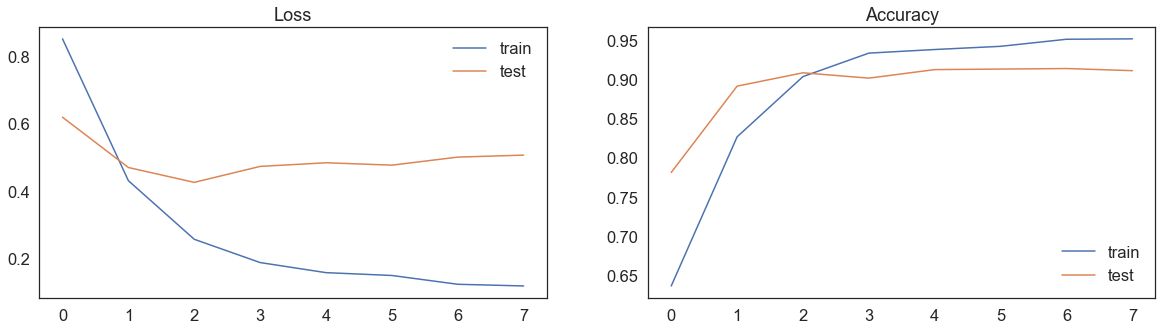

In [45]:
classifier3=run(model3)

## Performance of Final Model

In [46]:
def perform(model):
    display(model.summary())
    # Final evaluation of the model
    scores = model.evaluate(X_test, y_test, verbose=0)
    print("Test Loss: %f" % (scores[0]))
    print("Test Accuracy: %f%%" % (scores[1]*100))
    return

In [47]:
def confusion(model):
    y_pred=model.predict(X_test)
    
    # Confusion Matrix
    y_predict=pd.Series([activities[i+1] for i in np.argmax(y_pred, axis=1)])
    y_actual=pd.Series([activities[i+1] for i in np.argmax(y_test, axis=1)])


    # Code for drawing seaborn heatmaps
    class_names = list(activities.values())
    df_heatmap = pd.DataFrame(confusion_matrix(y_actual, y_predict) )

    plt.style.use('seaborn-whitegrid')
    sns.set(style="white", font_scale = 1.5)

    fig = plt.figure(figsize=(15,12))
    heatmap = sns.heatmap(df_heatmap, annot=True, fmt="d", cmap="Blues")

    # Setting tick labels for heatmap
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right')
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=30, ha='right')
    heatmap.set_xticklabels(class_names)
    heatmap.set_yticklabels(class_names)
    plt.ylabel('Actual Activity')
    plt.xlabel('Predicted Activity')
    plt.title("Confusion Matrix\n")
    #plt.savefig("graph/Confusion Matrix.png")
    plt.show()
    return y_predict, y_actual

In [58]:
def class_report(model , y_predict , y_actual):
    cr=classification_report(y_actual, y_predict, target_names=activities.values(), digits=4)
    print(cr)

In [67]:
def final_performance(model):
    perform(model)
    y_predict, y_actual = confusion(model)
    class_report(model , y_predict , y_actual)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_1 (TimeDist (None, None, 30, 64)      1792      
_________________________________________________________________
time_distributed_2 (TimeDist (None, None, 15, 64)      0         
_________________________________________________________________
time_distributed_3 (TimeDist (None, None, 15, 64)      0         
_________________________________________________________________
time_distributed_4 (TimeDist (None, None, 13, 128)     24704     
_________________________________________________________________
time_distributed_5 (TimeDist (None, None, 6, 128)      0         
_________________________________________________________________
time_distributed_6 (TimeDist (None, None, 6, 128)      0         
_________________________________________________________________
time_distributed_7 (TimeDist (None, None, 768)        

None

Test Loss: 0.380889
Test Accuracy: 89.345098%


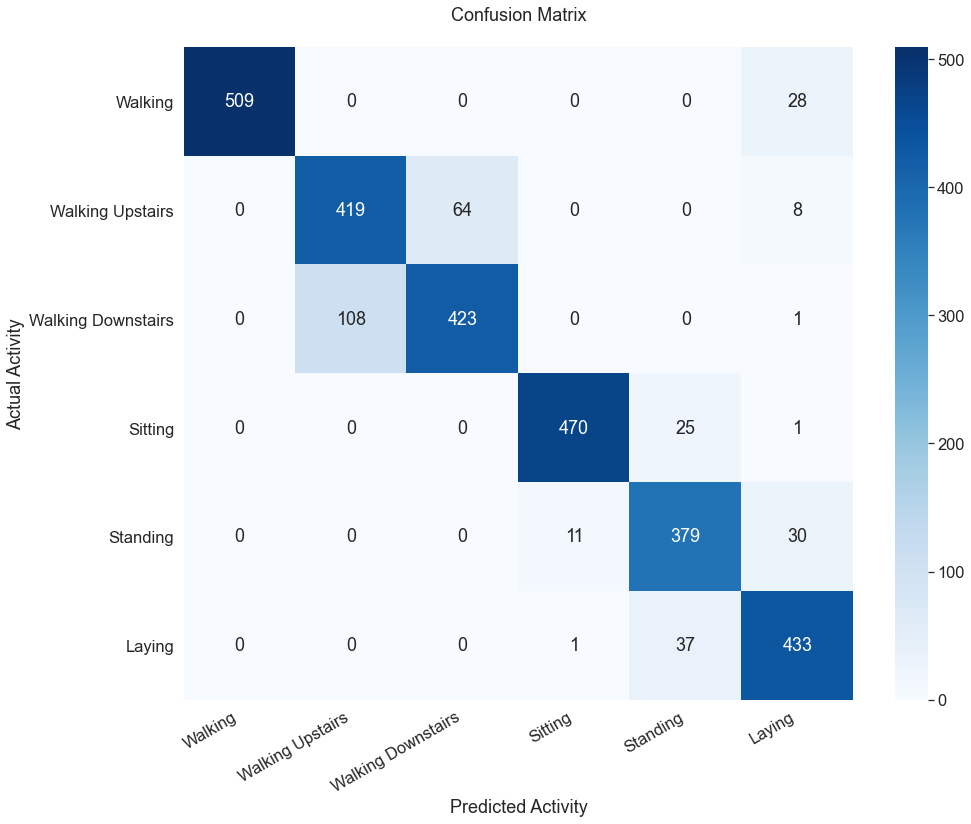

                    precision    recall  f1-score   support

           Walking     1.0000    0.9479    0.9732       537
  Walking Upstairs     0.7951    0.8534    0.8232       491
Walking Downstairs     0.8686    0.7951    0.8302       532
           Sitting     0.9751    0.9476    0.9611       496
          Standing     0.8594    0.9024    0.8804       420
            Laying     0.8643    0.9193    0.8909       471

          accuracy                         0.8935      2947
         macro avg     0.8937    0.8943    0.8932      2947
      weighted avg     0.8962    0.8935    0.8940      2947



In [68]:
final_performance(classifier3)